# Assignment A4: Mathematical Morphology

**CS6640**

**Cade Parkison**

---

In [1]:
format compact

In [35]:
%plot inline

### Problem 1

Develop a Matlab function using the erosion, dilation, and hit-or-miss transforms (or
things in bwmorph) to provide the best set of pixels corresponding to each moving object
in a given difference frame image (i.e., abs(background-frame)). Explore pre-processing
operations that may improve the results (e.g., gray scale transforms, color transforms, etc.).
Test your method on the videos provided in the class web page ’data/A4’ sub-directory.
Discuss your work carefully.

#### Functions

In [264]:
%%file CS6640_MM.m

function M = CS6640_MM(vidObj)
% CS6640_MM - segments moving objects in video
% On input:
%     vidObj (video object obtained by VideoReader): input video
% On output:
%     M (Matlab movie): movie of segmented moving objects
% Call:
%     vidObj = VideoReader(’../../../video.avi’);
%     M = CS6640_MM(vidObj);
% Author:
%     Cade Parkison
%     Fall 2018
%     UU
%

% Pause time to limit playback rate
p = 0;

k=1;

% Intensity threshold for establishing movement
threshold = 20;
while hasFrame(vidObj)
    vidFrame = double(rgb2gray(readFrame(vidObj)));

    % Initialize frames first time through
    if k==1
        im = vidFrame;
        im_subtract = im;
        ROW = size(vidFrame,1);
        COL = size(vidFrame,2);
        im_tracks = zeros(ROW, COL);
    else
        % Find movement by checking sequential frames
        im_subtract = vidFrame - im_last;
    end
    
    % Save current image for next procesing loop
    im_last = vidFrame;
    
    % capture movement and use a threshold to filter small variances
    im_movement = im_subtract > threshold;
      
    %%%%%%%%%%%%
    % MORPHOLOGY
    %%%%%%%%%%%%
    
    strel1 = strel('disk',1);
    im_open = imopen(im_movement,strel1);
    
    %im_open = bwareaopen(im_open,7);
    
    strel2 = strel('rectangle', [40,65]);
    %strel2 = strel('disk', 20);
    im_dil = imdilate(im_open, strel2);
    
    %im_fill = imfill(im_dil, 'holes');
    
    strel3 = strel('rectangle', [20,25]);
    %strel3 = strel('disk', 10);
    im_erode = imerode(im_dil, strel3);
    
    %%%%%%%%%%%%
    
    % Capture video
    figure(1);
    imshow(im_erode);
    M(k) = getframe(gca);
    %pause(p);

    k = k+1;
end

end

Created file 'C:\Users\cadep\School\CS_6640\A4\CS6640_MM.m'.


**MORPH HISTORY:**

- Threshold adjustments
- Size adjustments of Strel 2, trying to dilate large enough to close objects
- Shape of strel comparison

**Issues:**

- Trees splitting car into two objects
- cars passing by each other

---

#### Testing

### matlab: regionprops

In [209]:
%plot native

In [248]:
clear all;close all;clc

In [249]:
video1 = VideoReader('video1.avi');
video1b = VideoReader('video1.avi');
video2 = VideoReader('video2.avi');
video2b = VideoReader('video2.avi');
video3 = VideoReader('video3.avi');
video3b = VideoReader('video3.avi');

In [250]:
video = video1;
video_b = video1b;
M1 = CS6640_MM(video);

In [251]:
M2 = CS6640_object_data(M1, video_b);

In [253]:
%plot inline

In [178]:
s = regionprops(bw,'centroid');
centroids = cat(1, s.Centroid);
centroids


centroids =

  140.2513  201.7430
  534.3017  108.9789




In [179]:
%plot inline

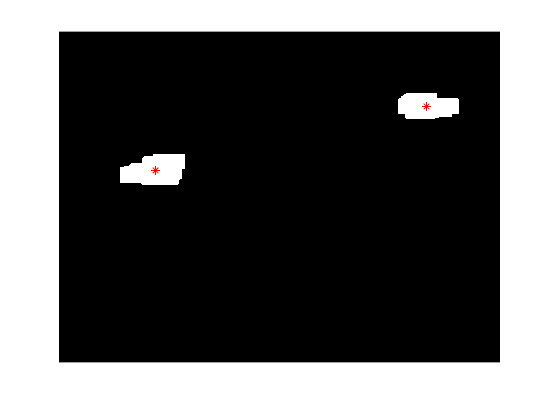

In [181]:
imshow(bw)
hold on
plot(centroids(:,1),centroids(:,2), 'r*')
hold off

In [190]:
t = M(1).cdata;
t = im2bw(t);
imshow(t)

In [192]:
s = regionprops(t,'centroid');
centroids = cat(1, s.Centroid)


centroids =

  320.5000  240.5000




---

### Problem 2

Develop a Matlab function to produce feature data for each moving object in each frame
in a movie produced by CS6640 MM. The features are:
1. object row mean
2. object column mean
3. row of upper left corner of bounding box
4. column of upper left corner of bounding box
5. row of lower right corner of bounding box
6. column of lower right corner of bounding box
7. number of pixels in object
8. red channel median of object pixels
9. green channel median of object pixels
10. blue channel median of object pixels
Test your method on the videos in ’data/A4’ along with objects from your CS6640 MM,
and discuss your work carefully.


#### Functions

In [545]:
%%file CS6640_object_data.m

function Object_data = CS6640_object_data(M,vidObj)
%
% On input:
%     M (Matlab movie): movie of segmented moving objects
%     vidObj (video object obtained by VideoReader): input video
% On output:
%     object_data (struct vector): object data
%       (k).num_objects (int): number of objects in frame k
%       (k).objects (struct vector): has features for each object (p)
%         objects(p).row_mean (float): row mean
%         objects(p).col_mean (float): column mean
%         objects(p).ul_row (int): upper left row for bounding box
%         objects(p).ul_col (int): upper left col for bounding box
%         objects(p).lr_row (int): lower right row for bounding box
%         objects(p).lr_col (int): lower right col for bounding box
%         objects(p).num_pixels (int): number of pixels
%         objects(p).red_median (int): median red value for object
%         objects(p).green_median (int): median green value for object
%         objects(p).blue_median (int): median blue value for object
% Call:
%     obj_data = CS6640_object_data(M,vidObj);
% Author:
%     Cade Parkison
%     Fall 2018
%     UU
%

p = 0.1;

frames = length(M);
Object_data = struct();

for f=1:frames
    vidFrame = read(vidObj, f);
    im = M(f).cdata;
    im_bw = im2bw(im);

    data = regionprops(im_bw);
    
    Object_data(f).num_objects = length(data);
    Object_data(f).objects = struct();
    
    % Some frames return no data, if so, create struct of all zeros so program does not fail
    if length(data) == 0
        s = struct('Area', 0, 'Centroid', [1,1], 'BoundingBox', [0,0,0,0]);
    else
        s = data;
    end
    
    for p=1:length(s)
    
        Object_data(f).objects(p).row_mean  = s(p).Centroid(2);
        Object_data(f).objects(p).col_mean  = s(p).Centroid(1);
        
        Object_data(f).objects(p).ul_row = s(p).BoundingBox(2);
        Object_data(f).objects(p).ul_col = s(p).BoundingBox(1);
        Object_data(f).objects(p).lr_row = s(p).BoundingBox(2) + s(p).BoundingBox(4);
        Object_data(f).objects(p).lr_col = s(p).BoundingBox(1) + s(p).BoundingBox(3);
        
        Object_data(f).objects(p).num_pixels = s(p).Area;
        
        % Average RGB Values
        
        % round centroid to nearest pixel
        c = round(s(p).Centroid);
        
        % box centered around centroid that is half height and half width of bounding box 
        w = int32(s(p).BoundingBox(3)/4);
        h = int32(s(p).BoundingBox(4)/4);
        rgb = vidFrame(c(2)-w:c(2)+w, c(1)-h:c(1)+h, :);
        
        % separate rgb values
        r = rgb(:,:,1);
        g = rgb(:,:,2);
        b = rgb(:,:,3);
        
        % get median values
        Object_data(f).objects(p).red_median = median(r(:));
        Object_data(f).objects(p).green_median = median(g(:));
        Object_data(f).objects(p).blue_median = median(b(:));
    end
    
    
    %figure(1);
    %imshow(vidFrame);
    %if length(centroids) > 0
        %hold on
        %plot(centroids(:,1),centroids(:,2), 'r*')
        %hold off
    %end
    
    %M(f) = getframe(gcf);
    
    %pause(p);

end


Created file 'C:\Users\cadep\School\CS_6640\A4\CS6640_object_data.m'.


#### Testing

In [544]:
int32(0.9)


ans =

  int32

   1




In [474]:
%plot native

In [491]:
clear all;close all;clc

In [492]:
video1 = VideoReader('video1.avi');
video1b = VideoReader('video1.avi');
video2 = VideoReader('video2.avi');
video2b = VideoReader('video2.avi');
video3 = VideoReader('video3.avi');
video3b = VideoReader('video3.avi');

In [493]:
video = video1;
video_b = video1b;
M1 = CS6640_MM(video);

In [547]:
Object_data1 = CS6640_object_data(M1, video_b);

In [548]:
Object_data1(1).objects


ans = 

  struct with fields:

        row_mean: 240.5000
        col_mean: 320.5000
          ul_row: 0.5000
          ul_col: 0.5000
          lr_row: 480.5000
          lr_col: 640.5000
      num_pixels: 307200
      red_median: 103
    green_median: 101
     blue_median: 93




In [505]:
%plot inline

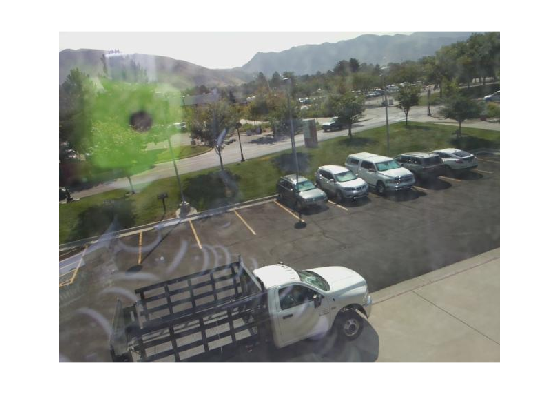

In [514]:
vidFrame = read(video_b, 30);


imshow(vidFrame)

In [525]:
rgb = vidFrame(10:200,10:200,:);
size(vidFrame), size(rgb)


ans =

   480   640     3


ans =

   191   191     3




In [534]:
a = rgb(:,:,1);
size(a(:))


ans =

       36481           1




In [535]:
median(a(:))


ans =

  uint8

   131




In [487]:
frames = 75;
for f=1:frames
    vidFrame = read(video_b, f);
    im = M1(f).cdata;
    im_bw = im2bw(im);

    s = regionprops(im_bw);
    for p=1:length(s)
        c = round(s(p).Centroid);
        disp(c)
        %rgb = vidFrame(c(2), c(1), :);

        %red_median = rgb(1);
        %green_median = rgb(2);
        %blue_median = rgb(3);
    end
    
    
end

   321   241

   480   118

   628    84

   441   122

   627    99

   421   125

   623    99

   415   126

   618    99

   405   130

   616    99

   404   128

   592   101

   341   146

   459   107

   551   103

   299   155

   499   105

   279   158

   502   105

   256   164

   483   111

   624    95

   214   171

   478   112

   628    89

   170   180

   472   114

   108   197

   463   116

    53   204

   464   116

    26   205

   466   116

   468   118

   490   113

   456   118

   620    91

   487   114

   387   135

   550   102

   360   141

   565   101

   334   149

   570   100

   306   153

   577    96

   270   160

   531   113

   624    84

   236   168

   517   113

   225   170

   503   115

   196   176

   484   119

   161   185

   477   121

   615    97

    15   229

   117   206

   432   129

   620    93

    30   211

   398   136

   617    93

    47   213

   392   138

   610    94

    57   218

   323   151

   613

In [381]:
b = struct('Area', 0, 'Centroid', [0,0], 'BoundingBox', [0,0,0,0]);

In [384]:
round(b(1).Centroid)


ans =

     0     0




In [268]:
%plot inline

In [297]:
length(M1)


ans =

    75




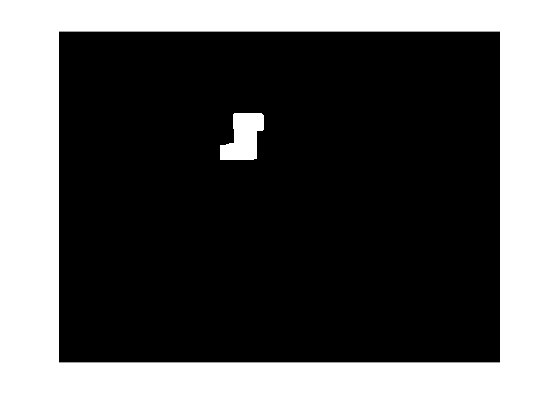

In [421]:
im = M1(68).cdata;
im = im2bw(im);
imshow(im)

In [423]:
s = regionprops(im)


s = 

  struct with fields:

           Area: 3057
       Centroid: [268.7219 154.5561]
    BoundingBox: [234.5000 118.5000 63 69]




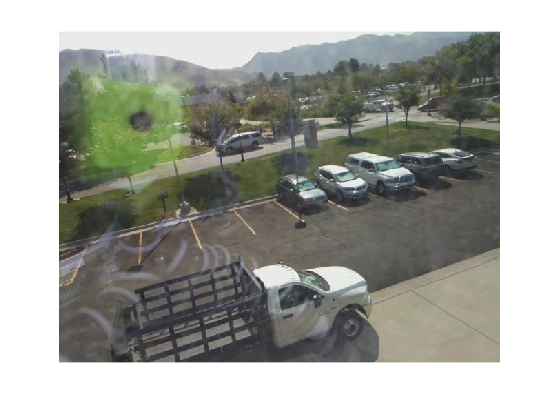

In [314]:
im2 = read(video_b, 10);
imshow(im2)

In [418]:
s = regionprops(im);
s


s = 

  0x1 empty struct array with fields:

    Area
    Centroid
    BoundingBox




In [321]:
c = round(s(1).Centroid)


c =

   279   158




In [326]:
rgb = im2(c(1), c(2), :);
rgb(1),rgb(2),rgb(3)


  1x1x3 uint8 array

rgb(:,:,1) =

   174


rgb(:,:,2) =

   171


rgb(:,:,3) =

   178


ans =

  uint8

   174


ans =

  uint8

   171


ans =

  uint8

   178




In [319]:
round(c(1))


ans =

   279




In [416]:
s = struct('Area', 0, 'Centroid', [0,0], 'BoundingBox', [0,0,0,0])
round(s(1).Centroid)


s = 

  struct with fields:

           Area: 0
       Centroid: [0 0]
    BoundingBox: [0 0 0 0]


ans =

     0     0




Bounding Box: ( ul_corner_x, ul_corner_y, x_width, y_width )

In [309]:
s(1).BoundingBox


ans =

  218.5000  134.5000  114.0000   47.0000




In [312]:
s(1).BoundingBox(2) + s(1).BoundingBox(4)


ans =

  181.5000




In [303]:
Object_data = struct();

In [302]:
Object_datas.Centroid


ans =

  279.0678  158.2784


ans =

  502.4892  105.4117




In [301]:
b = cat(1, s.Centroid)


b =

  279.0678  158.2784
  502.4892  105.4117




In [284]:
Object_data = struct();

In [290]:
Object_data(1).a = 1


Object_data = 

  struct with fields:

    a: 1




In [292]:
Object_data(2).a = 2


Object_data = 

  1x2 struct array with fields:

    a




In [294]:
Object_data(2)


ans = 

  struct with fields:

    a: 2




In [ ]:

centroids = cat(1, s.Centroid);
centroids

In [ ]:
imshow(im)
hold on
plot(centroids(:,1),centroids(:,2), 'r*')
hold off

In [ ]:
cc = bwconncomp(BW); 
stats = regionprops(cc, 'Area','Eccentricity'); 
idx = find([stats.Area] > 80 & [stats.Eccentricity] < 0.8); 
BW2 = ismember(labelmatrix(cc), idx);  